# Training the Baseline Model 

### Primary Goal: Train an accurate baseline model for the individual severe weather hazards. 

In this notebook, I'll provide a brief tutorial on how to train and evaluate a baseline model. It is not only helpful, but crucial to develop a simplier, baseline model against which to evaluate the skill of the machine learning model. 

In [1]:
# Import packages 
import pandas as pd
import numpy as np
import joblib

# Plotting code imports 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# We add the github package to our system path so we can import python scripts for that repo. 
import sys
sys.path.append('/home/samuel.varga/projects/2to6_hr_severe_wx/')
#sys.path.append('/home/samuel.varga/python_packages/ml_workflow/ml_workflow/')
sys.path.append('/home/samuel.varga/python_packages/ml_workflow/')
#print(sys.path)
#sys.path.remove(sys.path[8])
#sys.path.append('/home/monte.flora/python_packages/2to6_hr_severe_wx/')
from main.io import load_bl_data
#sys.path.remove('/home/monte.flora/python_packages/2to6_hr_severe_wx/main/')
from main.evaluator import baseline_cv_scorer
from sklearn.isotonic import IsotonicRegression

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Configuration variables (You'll need to change based on where you store your data)
base_path = '/work/mflora/ML_2TO6HR/data'
base_path='/work/samuel.varga/data/2to6_hr_severe_wx'

### Neighborhood Maximum Ensemble Probability (NMEP)

For the baseline system, we use a single variable approach in which we compute the ensemble probability and extract the maximum value within a track. To compute the ensemble probability ($EP$), we threshold a variable $f$ on some threshold $t$ for each ensemble member and compute the average number of members exceeding that threshold:
\begin{equation}
	        EP = \frac{1}{N}\sum_{i=1}^{N} f_i > t
\end{equation}

The following variables and their threshold are as follows: 
   * Tornado $\rightarrow$ Updraft Helicity (`uh_2ot5_instant`)
   * Severe Hail $\rightarrow$ HAILCAST (`hailcast`)
   * Severe Wind $\rightarrow$ 80-m wind speed (`ws_80`)
   
   
For the NMEP, we apply a local maximum value filter to each ensemble member prior to computing the $EP$. By finding the maximum value within some neighborhood, we are accounting for the spatial uncertainty. 

<div class="alert alert-block alert-warning"> <b>Task:</b> Per hazard and target variable, determine the most skillful threshold and scale   </div>

To improve the probabilistic guidance provided by the baseline system, we used [isotonic regression](https://scikit-learn.org/stable/modules/isotonic.html) to calibrate the probabilities. We used the cross-validation approach from [Platt 1999](http://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.41.1639) to train the calibration model where the prediction and target values on each validation set are concatenated together and then isotonic regression is fit on that combined dataset. 

## Step 1. Evaluate the NMEP at different thresholds and scales. 

As a first example, I've provided some code that evaluates the NMEP using cross-validation on the training dataset. Your goal will be to determine the best threshold and scale per hazard. You'll want to create a figure similar to Fig. 1 in [Loken et al. 2020](https://journals.ametsoc.org/view/journals/wefo/35/4/wafD190258.xml), which will be a great addition to your paper. 


In [3]:
# Uncomment and run this command to learn about the input args for the load_bl_data function.
help(load_bl_data)

Help on function load_bl_data in module main.io:

load_bl_data(base_path, target_col, mode, feature_col=None)
    Load the baseline dataset.
    
    Parameters
    ----------------
    base_path : path-like str
        Path to where the training or testing dataset is stored.
    
    target_col : str 
        The name of the target column 
        
     mode : 'train', 'test', or None
        Indicating whether to load the training or testing dataset.
        If None, then the original, unsplit dataset is loaded.    
        
    feature_col : str (default=None)
        The name of the feature column. If None, then return the full dataframe. 
        Useful for training the baseline model.



In [4]:
df, y, dates = load_bl_data(mode='train', 
                            target_col = 'hail_severe__36km',
#                            target_col = 'tornado_severe__36km',
#                            target_col = 'wind_severe__36km',
                            base_path = base_path) 

In [5]:
df

,hailcast__nmep_>0_5_45km,hailcast__nmep_>0_75_45km,hailcast__nmep_>1_0_45km,hailcast__nmep_>1_25_45km,hailcast__nmep_>1_5_45km,uh_2to5_instant__nmep_>50_45km,uh_2to5_instant__nmep_>75_45km,uh_2to5_instant__nmep_>100_45km,uh_2to5_instant__nmep_>125_45km,uh_2to5_instant__nmep_>150_45km,...,tornado_severe__9km,hail_sig_severe__9km,wind_sig_severe__9km,tornado_sig_severe__9km,tornado_severe__54km,hail_severe__54km,wind_severe__54km,tornado_sig_severe__54km,hail_sig_severe__54km,wind_sig_severe__54km
0,0.055556,0.055556,0.0,0.0,0.0,0.111111,0.055556,0.055556,0.000000,0.0,...,0,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.055556,0.055556,0.055556,0.055556,0.0,...,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.055556,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764612,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
764613,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
764614,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
764615,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Uncomment and run to see the full list of features. 
#list(df.columns)

# Here is the breakdown for the naming convention 
# [hailcast|ws_80|uh_2to5_instant]__nmep__>[thresholds]_[9|27|45]km
#Prob is 0_5, 0_75, 1_0-- wrong
#help(baseline_cv_scorer)

Here is an example of how to use the `baseline_cv_scorer` function. You'll want to write a for loop to iterate over the different thresholds and scales. You'll want to keep the mean value for each set of `cv_scores`. Since you have two degrees of freedom (threshold and scale), the final figure will look like a heatmap. For an easy plotting example, look at the [seaborn heat map](https://seaborn.pydata.org/generated/seaborn.heatmap.html). 

In [7]:
X = df['hailcast__nmep_>1_0_9km']
cv_scores = baseline_cv_scorer(X, y, dates)

In [8]:
cv_scores

[0.0566476893575204,
 0.08326616471406267,
 0.07897676121261421,
 0.09762674045901243,
 0.06170224325523643]

<div class="alert alert-block alert-info"> <b>Tip</b> It may be useful to save the results so you can plot them later. </div>

In [9]:
#List of threshholds and scales
# [hailcast|ws_80|uh_2to5_instant]__nmep__>[thresholds]_[9|27|45]km

#Variables containing Name/title info
varNam=['hailcast','ws_80','uh_2to5_instant']
units=['in','m/s', 'm^2*s^-2']
thresh=list(np.ndarray((3,7), dtype=str)) #2D array used to hold threshold values for each variable as strings
thresh[0]=['0_5','0_75','1_0','1_25','1_5', '', '']
thresh[2]=[50,75,100,125,150,175,200]
thresh[1]=['30','40','50','60', '', '', '']
scales=['9','27','45']

#array of shape {Max number of thresholds} x {Number of scales}
mean_cv_scores=np.ones((7,3))*-999 #Shape of mean_cv_scores is [var_name, threshold, scale]

#I'm sure there is a prettier way to do this without nested loops, so I'll update this if I think of it
v=0
for j, p in enumerate(thresh[v]):
        for k, s in enumerate(scales):
            #print([v,j,k])
            if v==0 and j>=5:
                continue
            elif v==1 and j>=4:
                continue
            #print([v,p,s])
            else:
                X=df['{}__nmep_>{}_{}km'.format(varNam[v],p,s)]
                mean_cv_scores[j,k]=np.nanmean(baseline_cv_scorer(X,y,dates))
                #print([v,j,k])

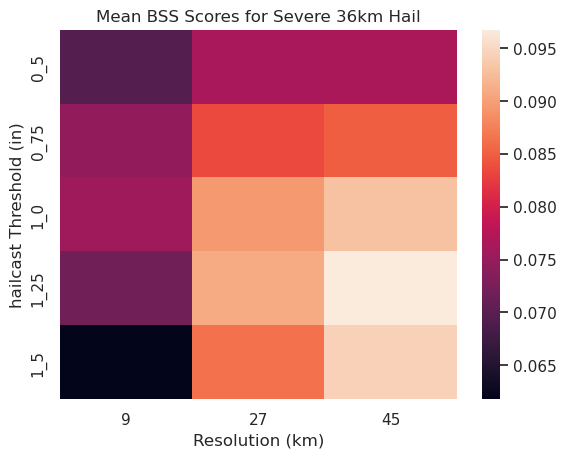

['1_25', '45']
0.09674586800903613


In [10]:
#Heatmap for 36km hail
ma_mean_cv_scores=np.ma.masked_where(mean_cv_scores<=0, mean_cv_scores) #Compress to remove the masked values
Heat2D=np.reshape(np.ma.compressed(ma_mean_cv_scores), (5,3)) #reshape into 2D (n X 3) array of BSS
fig, ax = plt.subplots()
sns.heatmap(Heat2D, ax=ax)
ax.set_xlabel('Resolution (km)')
ax.set_xticklabels(scales)
ax.set_ylabel('{} Threshold ({})'.format(varNam[v],units[v])) #Check units for this
ax.set_yticklabels(thresh[v][:len(Heat2D)]) #The indexing is a little funky bc this is a python list, not np.array
ax.set_title('Mean BSS Scores for Severe 36km Hail')
plt.show()

#There is definitely a more efficient way to do this

#Print statements for sanity checks
bestInd=np.unravel_index(np.argmax(Heat2D),Heat2D.shape)
print([thresh[v][bestInd[0]],scales[bestInd[1]]])
print(Heat2D[bestInd[0],bestInd[1]])

## Step 2. Training the final, calibrated model 

Once you are confident about the best threshold and scale, you can train the final baseline model. 


In [11]:
def train_baseline(X,y,dates, save_name):
    """Train a baseline model and then save it."""
    clf = IsotonicRegression(out_of_bounds='clip', y_min=0, y_max=1)
    clf.fit(X, y)
    joblib.dump(clf, save_name, compress=4)

In [12]:
# Create a save path for the baseline model. 
workDir='/work/{}/projects/2to6_hr_severe_wx/blModels/'.format('samuel.varga') #Work directory
save_name = 'hail_baseline_model.joblib'
save_name=workDir+save_name
print(save_name)

#Load the optimal baseline data
X=df['{}__nmep_>{}_{}km'.format('hailcast','1_25','45')] #Need to update this to include the other two optimal vars
train_baseline(X,y,dates, save_name)

#Model has to be trained for the best threshold and prob for each hazard

/work/samuel.varga/projects/2to6_hr_severe_wx/blModels/hail_baseline_model.joblib


# Step 3. Repeating the Process for Wind

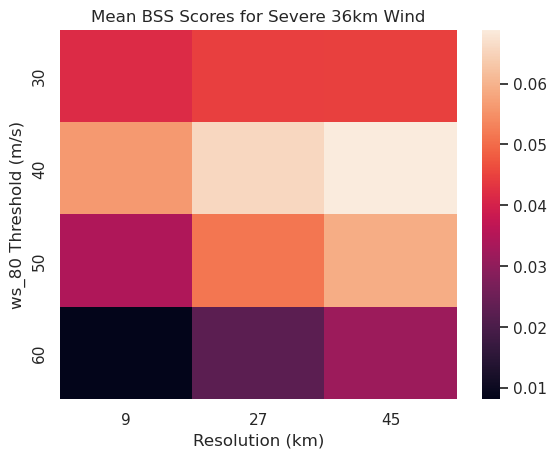

/work/samuel.varga/projects/2to6_hr_severe_wx/blModels/wind_baseline_model.joblib
['40', '45']
0.06885809012263364


In [13]:
#Load the target data
df, y, dates = load_bl_data(mode='train', 
                            target_col = 'wind_severe__36km',
                            base_path = base_path) 


#Reset the CV_scores
mean_cv_scores=np.ones((7,3))*-999 #Shape of mean_cv_scores is [var_name, threshold, scale]

#Switch to v=1 for wind
v=1

#CV_scores for each threshold and scale
for j, p in enumerate(thresh[v]):
        for k, s in enumerate(scales):
            #print([v,j,k])
            if v==0 and j>=5:
                continue
            elif v==1 and j>=4:
                continue
            #print([v,p,s])
            else:
                X=df['{}__nmep_>{}_{}km'.format(varNam[v],p,s)]
                mean_cv_scores[j,k]=np.nanmean(baseline_cv_scorer(X,y,dates))
                #print([v,j,k])
                
#Heatmap for 36km wind
ma_mean_cv_scores=np.ma.masked_where(mean_cv_scores<=0, mean_cv_scores) #Compress to remove the masked values
Heat2D=np.reshape(np.ma.compressed(ma_mean_cv_scores), (int(len(np.ma.compressed(ma_mean_cv_scores))/3),3)) #reshape into 2D array of BSS
fig, ax = plt.subplots()
sns.heatmap(Heat2D, ax=ax)
ax.set_xlabel('Resolution (km)')
ax.set_xticklabels(scales)
ax.set_ylabel('{} Threshold ({})'.format(varNam[v],units[v])) #Check units for this
ax.set_yticklabels(thresh[v][:len(Heat2D)]) #The indexing is a little funky bc this is a python list, not np.array
ax.set_title('Mean BSS Scores for Severe 36km Wind')
plt.show()


# Create a save path for the baseline model. 
workDir='/work/{}/projects/2to6_hr_severe_wx/blModels/'.format('samuel.varga') #Work directory
save_name = 'wind_baseline_model.joblib'
save_name=workDir+save_name
print(save_name)

#Grab the indices for the maximum CV_score
bestInd=np.unravel_index(np.argmax(Heat2D),Heat2D.shape)
print([thresh[v][bestInd[0]],scales[bestInd[1]]])
print(Heat2D[bestInd[0],bestInd[1]])
#Load the optimal baseline data and train the baseline model
X=df['{}__nmep_>{}_{}km'.format(varNam[v],thresh[v][bestInd[0]],scales[bestInd[1]])] 
train_baseline(X,y,dates, save_name)

# Step 4. Repeating the Process for Tornadoes

In [ ]:
#Load the target data
df, y, dates = load_bl_data(mode='train', 
                            target_col = 'tornado_severe__36km',
                            base_path = base_path) 


#Reset the CV_scores
mean_cv_scores=np.ones((7,3))*-999 #Shape of mean_cv_scores is [var_name, threshold, scale]

#Switch to v=2 for tornado
v=2

#CV_scores for each threshold and scale
for j, p in enumerate(thresh[v]):
        for k, s in enumerate(scales):
            #print([v,j,k])
            if v==0 and j>=5:
                continue
            elif v==1 and j>=4:
                continue
            #print([v,p,s])
            else:
                X=df['{}__nmep_>{}_{}km'.format(varNam[v],p,s)]
                mean_cv_scores[j,k]=np.nanmean(baseline_cv_scorer(X,y,dates))
                #print([v,j,k])
                
#Heatmap for 36km tornado
ma_mean_cv_scores=np.ma.masked_where(mean_cv_scores<=0, mean_cv_scores) #Compress to remove the masked values
Heat2D=np.reshape(np.ma.compressed(ma_mean_cv_scores), (int(len(np.ma.compressed(ma_mean_cv_scores))/3),3)) #reshape into 2D array of BSS
fig, ax = plt.subplots()
sns.heatmap(Heat2D, ax=ax)
ax.set_xlabel('Resolution (km)')
ax.set_xticklabels(scales)
ax.set_ylabel('{} Threshold ({})'.format(varNam[v],units[v])) #Check units for this
ax.set_yticklabels(thresh[v][:len(Heat2D)]) #The indexing is a little funky bc this is a python list, not np.array
ax.set_title('Mean BSS Scores for Severe 36km Tornado')
plt.show()


# Create a save path for the baseline model. 
workDir='/work/{}/projects/2to6_hr_severe_wx/blModels/'.format('samuel.varga') #Work directory
save_name = 'tornado_baseline_model.joblib'
save_name=workDir+save_name
print(save_name)

#Grab the indices for the maximum CV_score
bestInd=np.unravel_index(np.argmax(Heat2D),Heat2D.shape)
print(Heat2D[bestInd[0],bestInd[1]])
print([thresh[v][bestInd[0]],scales[bestInd[1]]])

#Load the optimal baseline data and train the baseline model
X=df['{}__nmep_>{}_{}km'.format(varNam[v],thresh[v][bestInd[0]],scales[bestInd[1]])] 
train_baseline(X,y,dates, save_name)

I'll leave this as a note for future me. The color bars for the heatmaps are all different, which I should address in the future. 